# Comprehensive EDA with statistical analysis and visualizations.

In [36]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datetime import datetime
import os
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100



## 1. Load Processed Data

In [37]:
# Setup paths
if os.path.basename(os.getcwd()) == 'notebooks':
    BASE_DIR = os.path.dirname(os.getcwd())
else:
    BASE_DIR = os.getcwd()

PROCESSED_DIR = os.path.join(BASE_DIR, 'data', 'processed')
FIGURES_DIR = os.path.join(BASE_DIR, 'reports', 'figures')
os.makedirs(FIGURES_DIR, exist_ok=True)

# Load data
movies = pd.read_csv(os.path.join(PROCESSED_DIR, 'movies_features.csv'))
train = pd.read_csv(os.path.join(PROCESSED_DIR, 'train.csv'))
tags = pd.read_csv(os.path.join(PROCESSED_DIR, 'tags_clean.csv'))
movie_tags = pd.read_csv(os.path.join(PROCESSED_DIR, 'movie_tags_aggregated.csv'))

print(f"Loaded: {len(movies):,} movies, {len(train):,} train ratings, {len(tags):,} tags")


Loaded: 62,423 movies, 20,000,076 train ratings, 1,092,394 tags


## 2. Rating Distribution Analysis

Saved: 01_rating_analysis.png


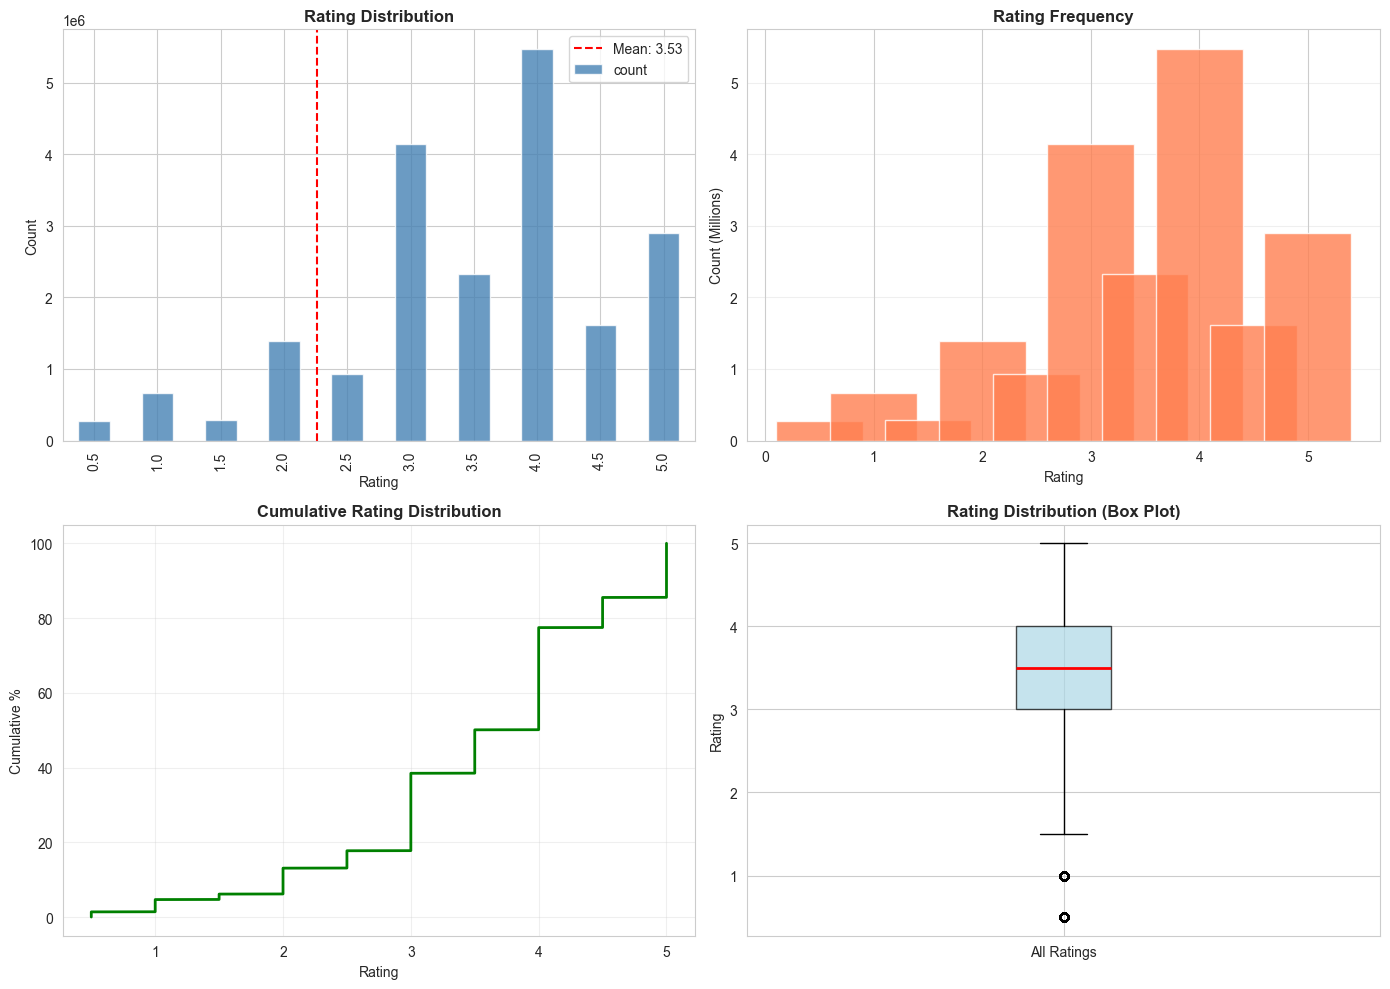


Rating Statistics:
Mean: 3.53
Median: 3.50
Std: 1.06
Mode: 4.0


In [38]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Rating distribution
ax = axes[0, 0]
train['rating'].value_counts().sort_index().plot(kind='bar', ax=ax, color='steelblue', alpha=0.8)
ax.set_title('Rating Distribution', fontsize=12, weight='bold')
ax.set_xlabel('Rating')
ax.set_ylabel('Count')
ax.axvline(train['rating'].mean(), color='red', linestyle='--', label=f'Mean: {train["rating"].mean():.2f}')
ax.legend()

# Rating statistics by percentile
ax = axes[0, 1]
rating_counts = train['rating'].value_counts().sort_index()
ax.bar(rating_counts.index, rating_counts.values / 1e6, color='coral', alpha=0.8)
ax.set_title('Rating Frequency', fontsize=12, weight='bold')
ax.set_xlabel('Rating')
ax.set_ylabel('Count (Millions)')
ax.grid(axis='y', alpha=0.3)

# Cumulative distribution
ax = axes[1, 0]
sorted_ratings = np.sort(train['rating'])
cumulative = np.arange(1, len(sorted_ratings) + 1) / len(sorted_ratings) * 100
ax.plot(sorted_ratings, cumulative, linewidth=2, color='green')
ax.set_title('Cumulative Rating Distribution', fontsize=12, weight='bold')
ax.set_xlabel('Rating')
ax.set_ylabel('Cumulative %')
ax.grid(alpha=0.3)

# Box plot
ax = axes[1, 1]
ax.boxplot(train['rating'], vert=True, patch_artist=True,
           boxprops=dict(facecolor='lightblue', alpha=0.7),
           medianprops=dict(color='red', linewidth=2))
ax.set_title('Rating Distribution (Box Plot)', fontsize=12, weight='bold')
ax.set_ylabel('Rating')
ax.set_xticklabels(['All Ratings'])

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '01_rating_analysis.png'), dpi=300, bbox_inches='tight')
print(f"Saved: 01_rating_analysis.png")
plt.show()

# Print statistics
print(f"\nRating Statistics:")
print(f"Mean: {train['rating'].mean():.2f}")
print(f"Median: {train['rating'].median():.2f}")
print(f"Std: {train['rating'].std():.2f}")
print(f"Mode: {train['rating'].mode()[0]:.1f}")

## 3. User & Movie Activity Patterns

Saved: 02_activity_patterns.png


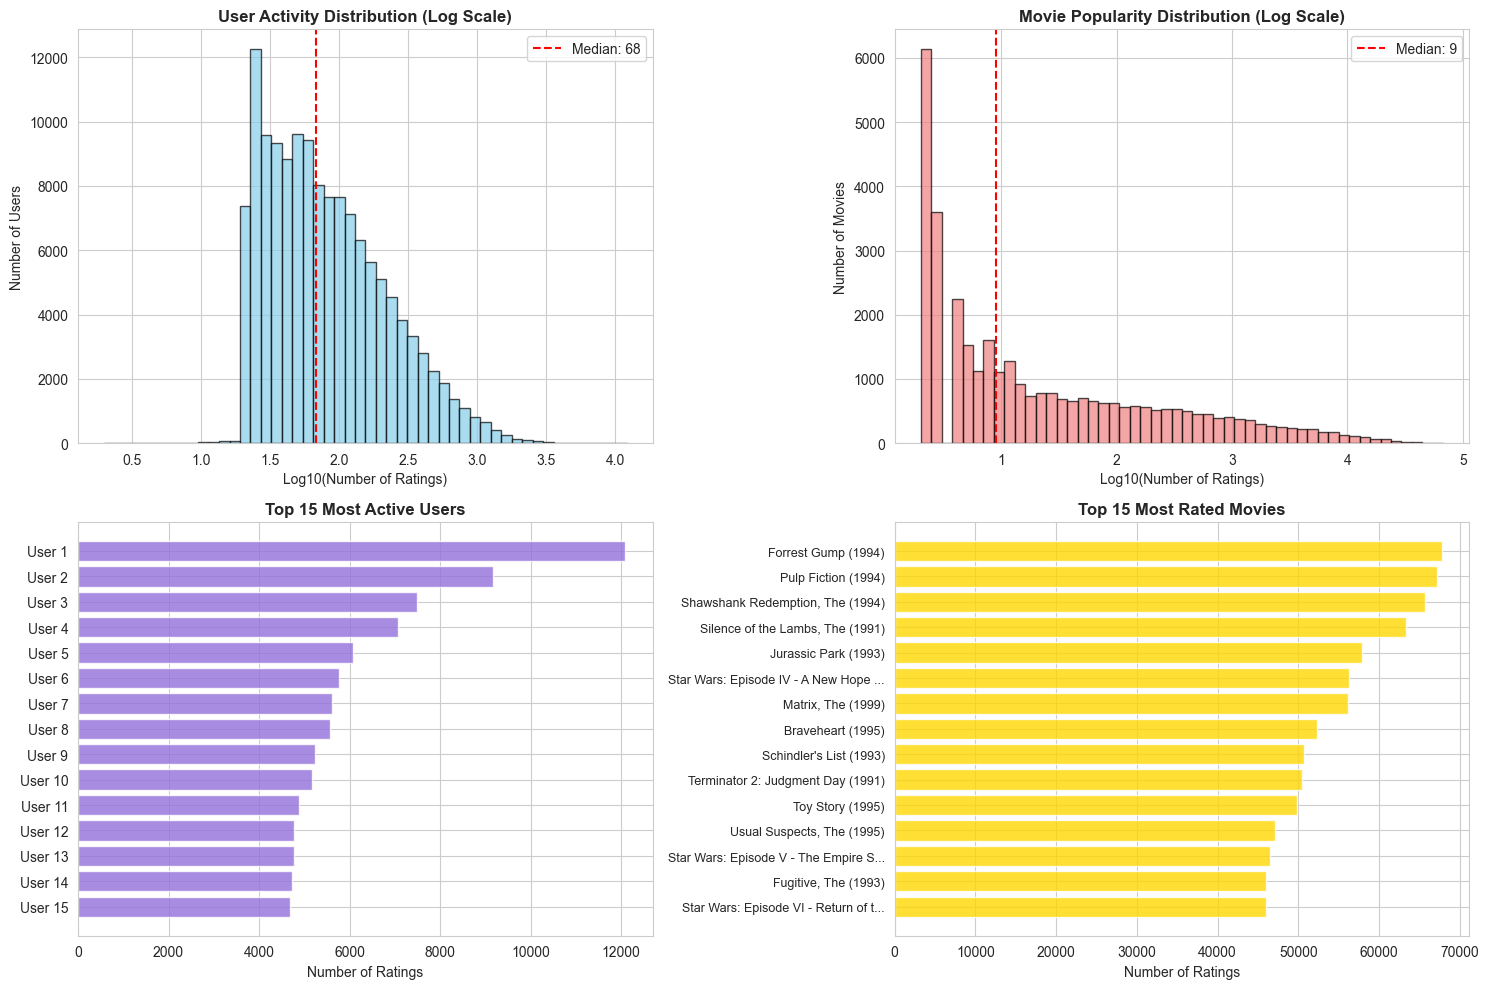


Activity Summary:
Users: 137,883 total
  - Median activity: 68 ratings
  - Power users (>500): 7,466
Movies: 34,461 total
  - Median popularity: 9 ratings
  - Blockbusters (>1000): 3,222


In [9]:
# Calculate activity
user_counts = train.groupby('userId').size()
movie_counts = train.groupby('movieId').size()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# User activity distribution (log scale)
ax = axes[0, 0]
ax.hist(np.log10(user_counts + 1), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax.set_title('User Activity Distribution (Log Scale)', fontsize=12, weight='bold')
ax.set_xlabel('Log10(Number of Ratings)')
ax.set_ylabel('Number of Users')
ax.axvline(np.log10(user_counts.median()), color='red', linestyle='--', label=f'Median: {user_counts.median():.0f}')
ax.legend()

# Movie popularity distribution (log scale)
ax = axes[0, 1]
ax.hist(np.log10(movie_counts + 1), bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
ax.set_title('Movie Popularity Distribution (Log Scale)', fontsize=12, weight='bold')
ax.set_xlabel('Log10(Number of Ratings)')
ax.set_ylabel('Number of Movies')
ax.axvline(np.log10(movie_counts.median()), color='red', linestyle='--', label=f'Median: {movie_counts.median():.0f}')
ax.legend()

# Top 15 most active users
ax = axes[1, 0]
top_users = user_counts.nlargest(15)
ax.barh(range(len(top_users)), top_users.values, color='mediumpurple', alpha=0.8)
ax.set_yticks(range(len(top_users)))
ax.set_yticklabels([f'User {i+1}' for i in range(len(top_users))])
ax.set_xlabel('Number of Ratings')
ax.set_title('Top 15 Most Active Users', fontsize=12, weight='bold')
ax.invert_yaxis()

# Top 15 most rated movies
ax = axes[1, 1]
top_movie_ids = movie_counts.nlargest(15).index
top_movie_titles = movies[movies['movieId'].isin(top_movie_ids)].set_index('movieId')['title']
top_movie_data = movie_counts[top_movie_ids]
ax.barh(range(len(top_movie_data)), top_movie_data.values, color='gold', alpha=0.8)
ax.set_yticks(range(len(top_movie_data)))
ax.set_yticklabels([top_movie_titles[mid][:35] + '...' if len(top_movie_titles[mid]) > 35 
                     else top_movie_titles[mid] for mid in top_movie_data.index], fontsize=9)
ax.set_xlabel('Number of Ratings')
ax.set_title('Top 15 Most Rated Movies', fontsize=12, weight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '02_activity_patterns.png'), dpi=300, bbox_inches='tight')
print(f"Saved: 02_activity_patterns.png")
plt.show()

print(f"\nActivity Summary:")
print(f"Users: {len(user_counts):,} total")
print(f"  - Median activity: {user_counts.median():.0f} ratings")
print(f"  - Power users (>500): {(user_counts > 500).sum():,}")
print(f"Movies: {len(movie_counts):,} total")
print(f"  - Median popularity: {movie_counts.median():.0f} ratings")
print(f"  - Blockbusters (>1000): {(movie_counts > 1000).sum():,}")

## 4. Genre Analysis

Saved: 03_genre_analysis.png


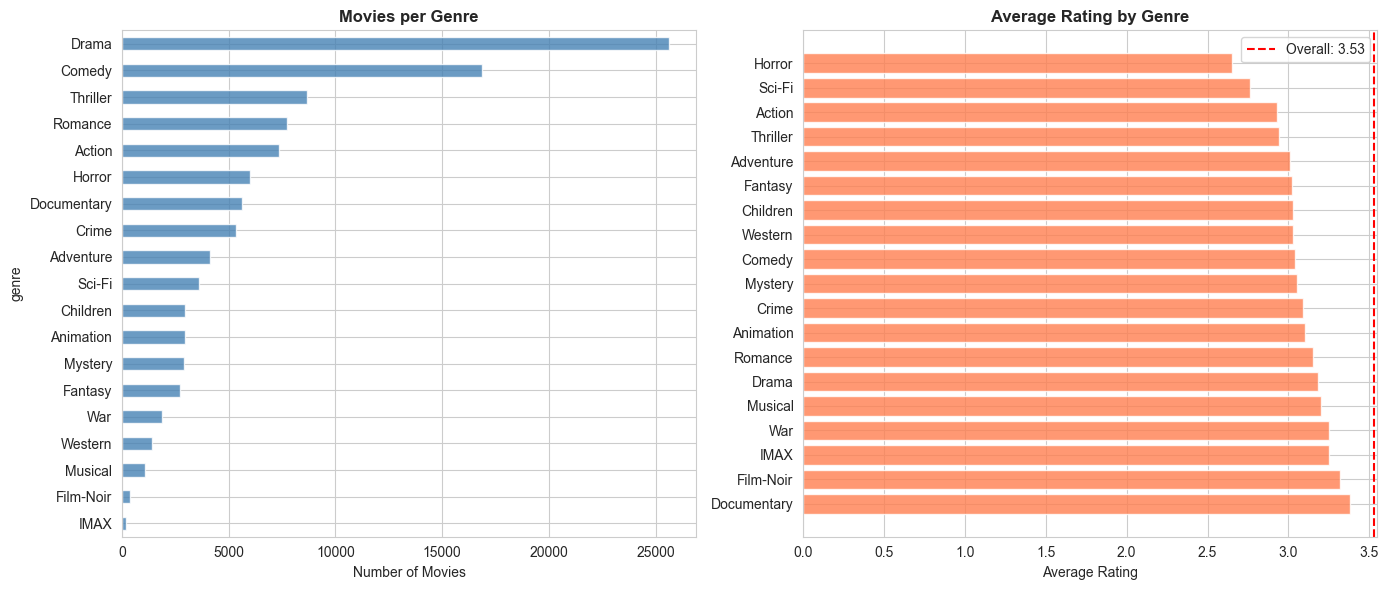


Top 5 Genres by Movie Count:
  Drama          : 25,606 movies (avg: 3.18★)
  Comedy         : 16,870 movies (avg: 3.04★)
  Thriller       : 8,654 movies (avg: 2.94★)
  Romance        : 7,719 movies (avg: 3.15★)
  Action         : 7,348 movies (avg: 2.93★)


In [23]:
genre_data = []
for idx, row in movies.iterrows():
    if pd.notna(row['genres']) and row['genres'] != '(no genres listed)':
        for genre in row['genres'].split('|'):
            genre_data.append({
                'genre': genre,
                'movieId': row['movieId'],
                'rating_mean': row['rating_mean'] if pd.notna(row['rating_mean']) else None,
                'rating_count': row['rating_count'] if pd.notna(row['rating_count']) else 0
            })

genre_df = pd.DataFrame(genre_data)

# Genre statistics
genre_stats = genre_df.groupby('genre').agg({
    'movieId': 'count',
    'rating_mean': 'mean',
    'rating_count': 'sum'
}).round(2)
genre_stats.columns = ['movie_count', 'avg_rating', 'total_ratings']
genre_stats = genre_stats.sort_values('movie_count', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Genre frequency
ax = axes[0]
genre_stats['movie_count'].plot(kind='barh', ax=ax, color='steelblue', alpha=0.8)
ax.set_title('Movies per Genre', fontsize=12, weight='bold')
ax.set_xlabel('Number of Movies')
ax.invert_yaxis()

# Average rating by genre
ax = axes[1]
genre_stats_sorted = genre_stats.sort_values('avg_rating', ascending=True)
ax.barh(range(len(genre_stats_sorted)), genre_stats_sorted['avg_rating'], color='coral', alpha=0.8)
ax.set_yticks(range(len(genre_stats_sorted)))
ax.set_yticklabels(genre_stats_sorted.index)
ax.axvline(train['rating'].mean(), color='red', linestyle='--', label=f'Overall: {train["rating"].mean():.2f}')
ax.set_title('Average Rating by Genre', fontsize=12, weight='bold')
ax.set_xlabel('Average Rating')
ax.legend()
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '03_genre_analysis.png'), dpi=300, bbox_inches='tight')
print(f"Saved: 03_genre_analysis.png")
plt.show()

print(f"\nTop 5 Genres by Movie Count:")
for genre, stats in genre_stats.head().iterrows():
    print(f"  {genre:15s}: {stats['movie_count']:>5,.0f} movies (avg: {stats['avg_rating']:.2f}★)")


## 5. TEMPORAL PATTERNS & TIME SERIES ANALYSIS


TEMPORAL PATTERNS ANALYSIS

Preparing temporal features...
Time range: 1995-01-09 11:46:49 to 2016-06-25 06:49:57
Years covered: 1995 to 2016
Total ratings: 20,000,076

[12/15] Creating yearly trends visualization...
[13/15] Creating seasonal patterns visualization...
[14/15] Creating weekly patterns visualization...
[15/15] Creating hourly patterns visualization...

Visualization saved: c:\Users\mhfou\Documents\MovieRecommenderSystem\reports\figures\04_temporal_patterns.png


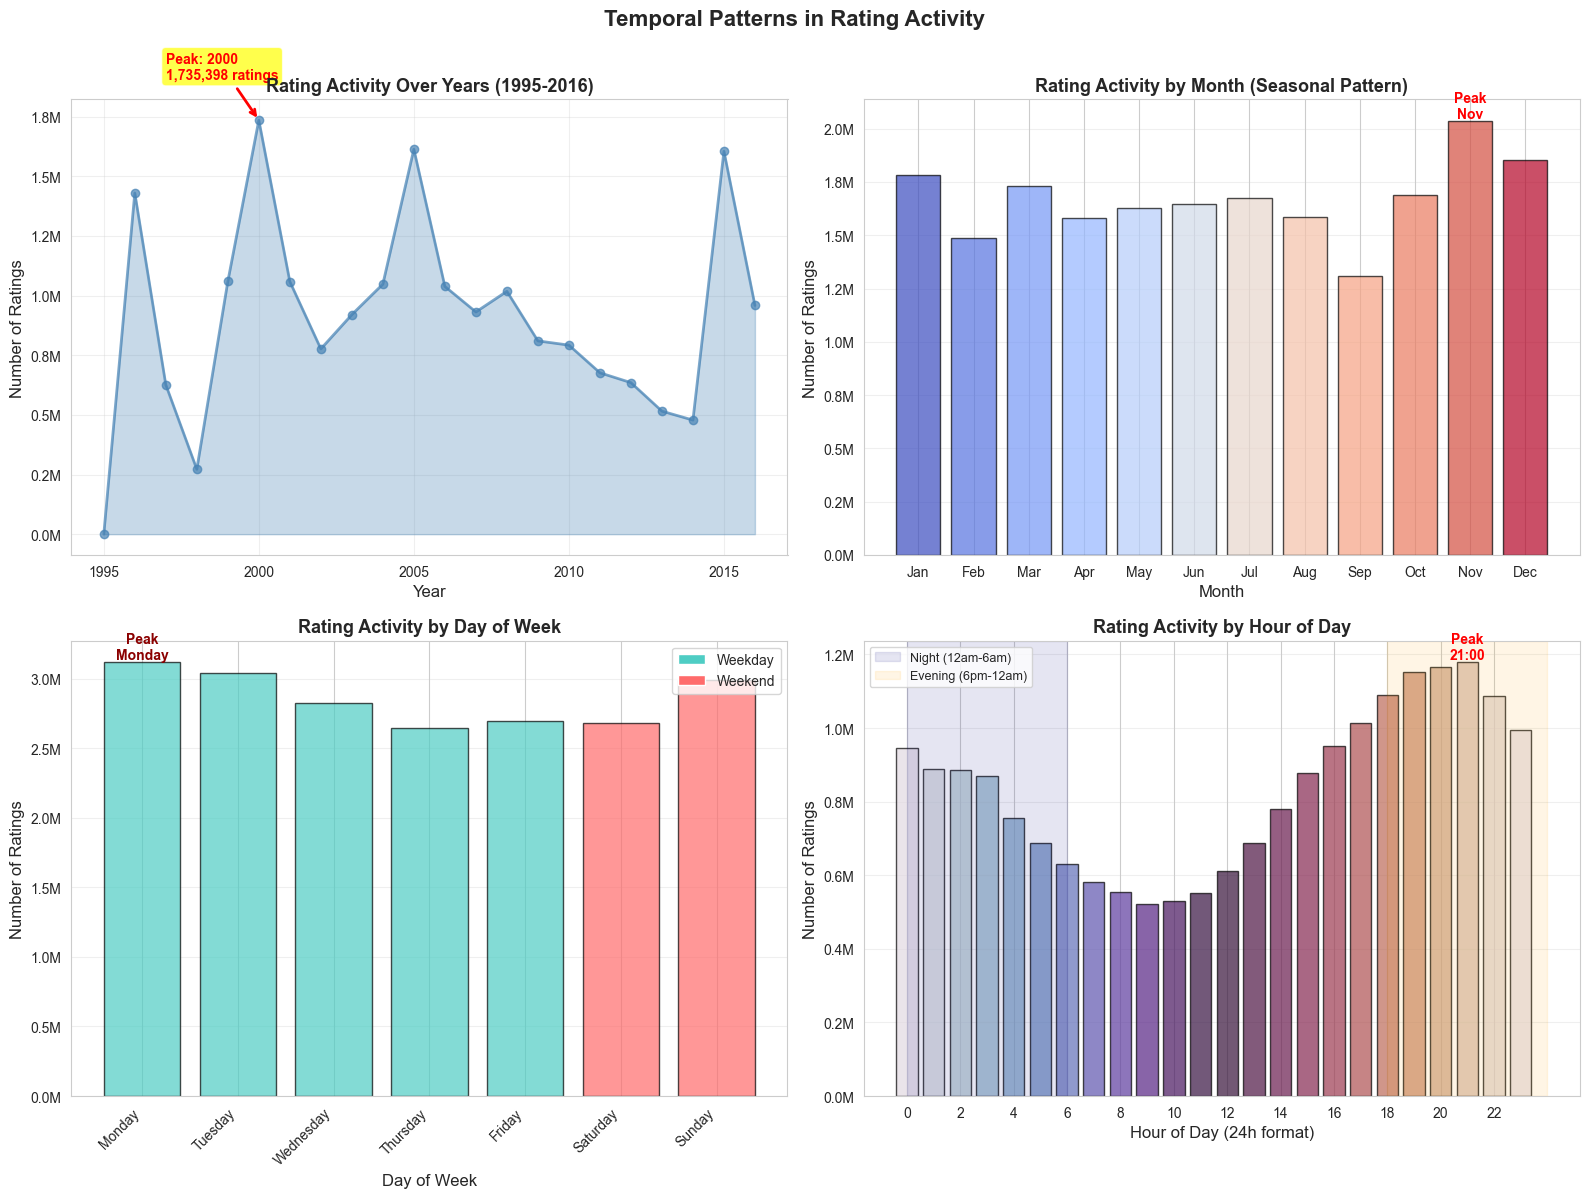


TEMPORAL INSIGHTS SUMMARY

YEARLY TRENDS:
  Peak year: 2000 with 1,735,398 ratings
  Growth rate: 57846500% increase from 1995 to 2000
  Average per year: 909,094 ratings

SEASONAL PATTERNS:
  Peak month: Nov (2,035,577 ratings)
  Lowest month: Sep (1,309,062 ratings)
  Seasonal variation: 55.5% difference between peak and low

WEEKLY PATTERNS:
  Peak day: Monday (3,118,323 ratings)
  Weekend activity: 5,671,558 ratings (28.4%)
  Weekday activity: 14,328,518 ratings (71.6%)

HOURLY PATTERNS:
  Peak hour: 21:00 (1,178,855 ratings)
  Night hours (0-6): 5,032,698 ratings (25.2%)
  Evening hours (18-24): 6,671,820 ratings (33.4%)

KEY INSIGHTS:
  - Users are most active in the evening hours (6pm-12am)
  - Weekend activity is lower than weekday activity
  - Nov shows peak seasonal activity
  - Rating activity peaked in 2000


In [19]:
# =============================================================================
# TEMPORAL PATTERNS ANALYSIS
# Visualizations 12-15: Time-based rating activity patterns
# =============================================================================


print("\n" + "=" * 80)
print("TEMPORAL PATTERNS ANALYSIS")
print("=" * 80)

# =============================================================================
# DATA PREPARATION
# =============================================================================

print("\nPreparing temporal features...")

# Extract datetime components from timestamp
train['datetime'] = pd.to_datetime(train['timestamp'], unit='s')
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day_of_week'] = train['datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
train['hour'] = train['datetime'].dt.hour

# Aggregate ratings by time periods
ratings_by_year = train.groupby('year').size()
ratings_by_month = train.groupby('month').size()
ratings_by_day = train.groupby('day_of_week').size()
ratings_by_hour = train.groupby('hour').size()

# Display time range information
print(f"Time range: {train['datetime'].min()} to {train['datetime'].max()}")
print(f"Years covered: {train['year'].min()} to {train['year'].max()}")
print(f"Total ratings: {len(train):,}")

# =============================================================================
# VISUALIZATION SETUP
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Temporal Patterns in Rating Activity', 
             fontsize=16, fontweight='bold', y=0.995)

# Helper function for formatting large numbers
def format_millions(x, p):
    """Format y-axis labels in millions"""
    return f'{x/1e6:.1f}M'

# =============================================================================
# VISUALIZATION 12: RATINGS OVER YEARS (TIME SERIES)
# =============================================================================

print("\n[12/15] Creating yearly trends visualization...")

ax1 = axes[0, 0]
ax1.plot(ratings_by_year.index, ratings_by_year.values, 
         marker='o', linewidth=2, markersize=6, 
         color='steelblue', alpha=0.7)
ax1.fill_between(ratings_by_year.index, ratings_by_year.values, 
                  alpha=0.3, color='steelblue')

# Styling
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Ratings', fontsize=12)
ax1.set_title('Rating Activity Over Years (1995-2016)', 
              fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(format_millions))

# Annotate peak year
peak_year = ratings_by_year.idxmax()
peak_value = ratings_by_year.max()
ax1.annotate(
    f'Peak: {peak_year}\n{peak_value:,} ratings',
    xy=(peak_year, peak_value), 
    xytext=(peak_year - 3, peak_value * 1.1),
    arrowprops=dict(arrowstyle='->', color='red', lw=2),
    fontsize=10, color='red', fontweight='bold',
    bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7)
)

# =============================================================================
# VISUALIZATION 13: RATINGS BY MONTH (SEASONAL PATTERN)
# =============================================================================

print("[13/15] Creating seasonal patterns visualization...")

ax2 = axes[0, 1]
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors = plt.cm.coolwarm(np.linspace(0, 1, 12))

bars = ax2.bar(range(1, 13), ratings_by_month.values, 
               color=colors, alpha=0.7, edgecolor='black')

# Styling
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(months, fontsize=10)
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Number of Ratings', fontsize=12)
ax2.set_title('Rating Activity by Month (Seasonal Pattern)', 
              fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(format_millions))

# Highlight peak month
peak_month = ratings_by_month.idxmax()
ax2.text(peak_month, ratings_by_month.max(), 
         f'\nPeak\n{months[peak_month-1]}',
         ha='center', va='bottom', 
         fontsize=10, fontweight='bold', color='red')

# =============================================================================
# VISUALIZATION 14: RATINGS BY DAY OF WEEK
# =============================================================================

print("[14/15] Creating weekly patterns visualization...")

ax3 = axes[1, 0]
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
        'Friday', 'Saturday', 'Sunday']

# Color weekends differently
colors_days = ['#FF6B6B' if i >= 5 else '#4ECDC4' for i in range(7)]

bars = ax3.bar(range(7), ratings_by_day.values, 
               color=colors_days, alpha=0.7, edgecolor='black')

# Styling
ax3.set_xticks(range(7))
ax3.set_xticklabels(days, fontsize=10, rotation=45, ha='right')
ax3.set_xlabel('Day of Week', fontsize=12)
ax3.set_ylabel('Number of Ratings', fontsize=12)
ax3.set_title('Rating Activity by Day of Week', 
              fontsize=13, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(format_millions))

# Add legend for weekday/weekend
legend_elements = [
    Patch(facecolor='#4ECDC4', label='Weekday'),
    Patch(facecolor='#FF6B6B', label='Weekend')
]
ax3.legend(handles=legend_elements, loc='upper right')

# Highlight peak day
peak_day = ratings_by_day.idxmax()
ax3.text(peak_day, ratings_by_day.max(), 
         f'\nPeak\n{days[peak_day]}',
         ha='center', va='bottom', 
         fontsize=10, fontweight='bold', color='darkred')

# =============================================================================
# VISUALIZATION 15: RATINGS BY HOUR OF DAY
# =============================================================================

print("[15/15] Creating hourly patterns visualization...")

ax4 = axes[1, 1]
colors_hours = plt.cm.twilight(np.linspace(0, 1, 24))

bars = ax4.bar(range(24), ratings_by_hour.values, 
               color=colors_hours, alpha=0.7, edgecolor='black')

# Styling
ax4.set_xticks(range(0, 24, 2))
ax4.set_xlabel('Hour of Day (24h format)', fontsize=12)
ax4.set_ylabel('Number of Ratings', fontsize=12)
ax4.set_title('Rating Activity by Hour of Day', 
              fontsize=13, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
ax4.yaxis.set_major_formatter(plt.FuncFormatter(format_millions))

# Shade time periods
ax4.axvspan(0, 6, alpha=0.1, color='navy', label='Night (12am-6am)')
ax4.axvspan(18, 24, alpha=0.1, color='orange', label='Evening (6pm-12am)')
ax4.legend(loc='upper left', fontsize=9)

# Highlight peak hour
peak_hour = ratings_by_hour.idxmax()
ax4.text(peak_hour, ratings_by_hour.max(), 
         f'\nPeak\n{peak_hour}:00',
         ha='center', va='bottom', 
         fontsize=10, fontweight='bold', color='red')

# =============================================================================
# SAVE FIGURE
# =============================================================================

plt.tight_layout()
save_path = os.path.join(FIGURES_DIR, '04_temporal_patterns.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\nVisualization saved: {save_path}")
plt.show()

# =============================================================================
# TEMPORAL INSIGHTS SUMMARY
# =============================================================================

print("\n" + "=" * 80)
print("TEMPORAL INSIGHTS SUMMARY")
print("=" * 80)

# Year trends
print("\nYEARLY TRENDS:")
print(f"  Peak year: {peak_year} with {peak_value:,} ratings")
growth_rate = (ratings_by_year[peak_year] / ratings_by_year[train['year'].min()] - 1) * 100
print(f"  Growth rate: {growth_rate:.0f}% increase from {train['year'].min()} to {peak_year}")
print(f"  Average per year: {ratings_by_year.mean():,.0f} ratings")

# Seasonal patterns
print("\nSEASONAL PATTERNS:")
print(f"  Peak month: {months[peak_month-1]} ({ratings_by_month.max():,} ratings)")
print(f"  Lowest month: {months[ratings_by_month.idxmin()-1]} ({ratings_by_month.min():,} ratings)")
seasonal_var = (ratings_by_month.max() / ratings_by_month.min() - 1) * 100
print(f"  Seasonal variation: {seasonal_var:.1f}% difference between peak and low")

# Weekly patterns
print("\nWEEKLY PATTERNS:")
print(f"  Peak day: {days[peak_day]} ({ratings_by_day.max():,} ratings)")
weekend_pct = ratings_by_day[5:].sum() / ratings_by_day.sum() * 100
weekday_pct = ratings_by_day[:5].sum() / ratings_by_day.sum() * 100
print(f"  Weekend activity: {ratings_by_day[5:].sum():,} ratings ({weekend_pct:.1f}%)")
print(f"  Weekday activity: {ratings_by_day[:5].sum():,} ratings ({weekday_pct:.1f}%)")

# Daily patterns
print("\nHOURLY PATTERNS:")
print(f"  Peak hour: {peak_hour}:00 ({ratings_by_hour.max():,} ratings)")
night_pct = ratings_by_hour[0:6].sum() / ratings_by_hour.sum() * 100
evening_pct = ratings_by_hour[18:24].sum() / ratings_by_hour.sum() * 100
print(f"  Night hours (0-6): {ratings_by_hour[0:6].sum():,} ratings ({night_pct:.1f}%)")
print(f"  Evening hours (18-24): {ratings_by_hour[18:24].sum():,} ratings ({evening_pct:.1f}%)")

# Key insights
print("\nKEY INSIGHTS:")
print("  - Users are most active in the evening hours (6pm-12am)")
print(f"  - Weekend activity is {'higher' if weekend_pct > weekday_pct else 'lower'} than weekday activity")
print(f"  - {months[peak_month-1]} shows peak seasonal activity")
print(f"  - Rating activity peaked in {peak_year}")


## 6. TAG ANALYSIS & WORD CLOUDS


TAG ANALYSIS & NATURAL LANGUAGE PROCESSING

Preparing tag data...
Total tags: 1,092,394
Unique tags: 64,746
Top 50 tags represent 185,495 uses (17.0% of all tags)

[16/20] Creating top 30 tags visualization...
[17/20] Generating word cloud (all tags)...
[18/20] Generating word cloud (movie-aggregated tags)...
[19/20] Creating tag length distribution...
[20/20] Creating tags per movie distribution...

Visualization saved: c:\Users\mhfou\Documents\MovieRecommenderSystem\reports\figures\05_tag_analysis_wordclouds.png


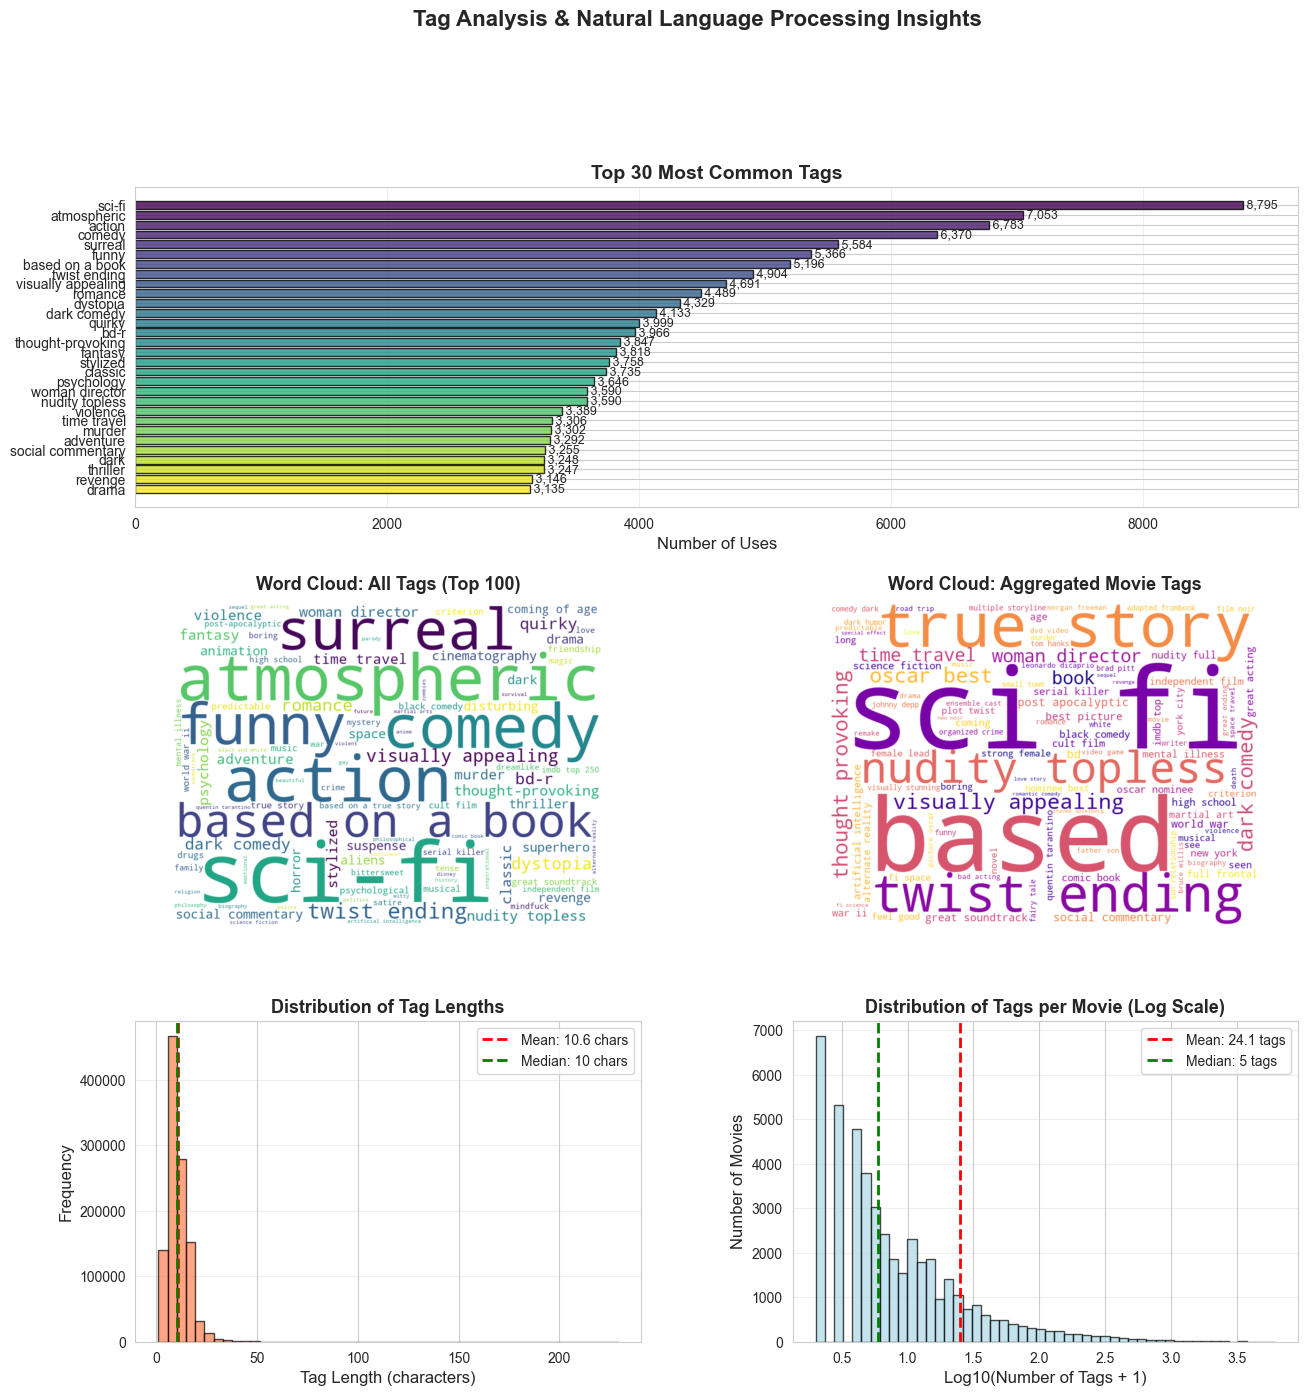


TAG STATISTICS SUMMARY

TAG USAGE:
  Total clean tags: 1,092,394
  Unique tags: 64,746
  Average tag length: 10.6 characters
  Median tag length: 10 characters

TOP 10 MOST POPULAR TAGS:
   1. sci-fi                         (  8,795 uses)
   2. atmospheric                    (  7,053 uses)
   3. action                         (  6,783 uses)
   4. comedy                         (  6,370 uses)
   5. surreal                        (  5,584 uses)
   6. funny                          (  5,366 uses)
   7. based on a book                (  5,196 uses)
   8. twist ending                   (  4,904 uses)
   9. visually appealing             (  4,691 uses)
  10. romance                        (  4,489 uses)

TAG DISTRIBUTION PER MOVIE:
  Movies with tags: 45249
  Average tags per movie: 24.1
  Median tags per movie: 5
  Max tags on one movie: 6,180

TAG DIVERSITY:
  Average unique tags per movie: 10.2
  Tag repetition rate: 57.7%
  Movies with >100 tags: 1,934 (4.3%)

KEY INSIGHTS:
  - Tags pro

In [41]:
# =============================================================================
# TAG ANALYSIS & NATURAL LANGUAGE PROCESSING
# Visualizations 16-20: Tag frequency, word clouds, and distribution analysis
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os

print("\n" + "=" * 80)
print("TAG ANALYSIS & NATURAL LANGUAGE PROCESSING")
print("=" * 80)

# =============================================================================
# DATA PREPARATION
# =============================================================================

print("\nPreparing tag data...")

# Use 'tags' instead of 'tags_clean' (which was loaded at the beginning)
# If tags need cleaning, apply it here
if 'tag' in tags.columns:
    tags_clean = tags.copy()
else:
    print("Warning: Expected 'tag' column not found in tags dataframe")
    tags_clean = tags

# Basic statistics
print(f"Total tags: {len(tags_clean):,}")
print(f"Unique tags: {tags_clean['tag'].nunique():,}")

# Get top tags
top_tags = tags_clean['tag'].value_counts().head(50)
print(f"Top 50 tags represent {top_tags.sum():,} uses ({top_tags.sum()/len(tags_clean)*100:.1f}% of all tags)")

# =============================================================================
# VISUALIZATION SETUP
# =============================================================================

fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# =============================================================================
# VISUALIZATION 16: TOP 30 MOST COMMON TAGS
# =============================================================================

print("\n[16/20] Creating top 30 tags visualization...")

ax1 = fig.add_subplot(gs[0, :])
top_30 = tags_clean['tag'].value_counts().head(30)
colors = plt.cm.viridis(np.linspace(0, 1, 30))
bars = ax1.barh(range(len(top_30)), top_30.values, color=colors, alpha=0.8, edgecolor='black')

# Styling
ax1.set_yticks(range(len(top_30)))
ax1.set_yticklabels(top_30.index, fontsize=10)
ax1.set_xlabel('Number of Uses', fontsize=12)
ax1.set_title('Top 30 Most Common Tags', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_30.values)):
    ax1.text(val, i, f' {val:,}', va='center', fontsize=9)

# =============================================================================
# VISUALIZATION 17: WORD CLOUD - ALL TAGS
# =============================================================================

print("[17/20] Generating word cloud (all tags)...")

ax2 = fig.add_subplot(gs[1, 0])

# Create word frequency dictionary
tag_freq = tags_clean['tag'].value_counts().to_dict()

# Generate word cloud
wordcloud = WordCloud(
    width=800, 
    height=600, 
    background_color='white',
    colormap='viridis',
    max_words=100,
    relative_scaling=0.5,
    min_font_size=10
).generate_from_frequencies(tag_freq)

ax2.imshow(wordcloud, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Word Cloud: All Tags (Top 100)', fontsize=13, fontweight='bold', pad=10)

# =============================================================================
# VISUALIZATION 18: WORD CLOUD - MOVIE-SPECIFIC TAGS
# =============================================================================

print("[18/20] Generating word cloud (movie-aggregated tags)...")

ax3 = fig.add_subplot(gs[1, 1])

# Combine all aggregated movie tags
if 'tags_text' in movie_tags.columns:
    all_movie_tags_text = ' '.join(movie_tags['tags_text'].dropna().astype(str))
else:
    # Fallback: use tags column or create from tag column
    print("Note: 'tags_text' column not found, using alternative approach")
    all_movie_tags_text = ' '.join(tags_clean['tag'].astype(str))

# Generate word cloud from movie-level tags
wordcloud_movies = WordCloud(
    width=800, 
    height=600,
    background_color='white',
    colormap='plasma',
    max_words=100,
    relative_scaling=0.5,
    min_font_size=10
).generate(all_movie_tags_text)

ax3.imshow(wordcloud_movies, interpolation='bilinear')
ax3.axis('off')
ax3.set_title('Word Cloud: Aggregated Movie Tags', fontsize=13, fontweight='bold', pad=10)

# =============================================================================
# VISUALIZATION 19: TAG LENGTH DISTRIBUTION
# =============================================================================

print("[19/20] Creating tag length distribution...")

ax4 = fig.add_subplot(gs[2, 0])

tag_lengths = tags_clean['tag'].str.len()
ax4.hist(tag_lengths, bins=50, color='coral', alpha=0.7, edgecolor='black')

# Styling
ax4.set_xlabel('Tag Length (characters)', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Distribution of Tag Lengths', fontsize=13, fontweight='bold')
ax4.axvline(tag_lengths.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {tag_lengths.mean():.1f} chars')
ax4.axvline(tag_lengths.median(), color='green', linestyle='--', linewidth=2,
            label=f'Median: {tag_lengths.median():.0f} chars')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# =============================================================================
# VISUALIZATION 20: TAGS PER MOVIE DISTRIBUTION
# =============================================================================

print("[20/20] Creating tags per movie distribution...")

ax5 = fig.add_subplot(gs[2, 1])

# Get tag counts per movie
if 'tag_count' in movie_tags.columns:
    tags_per_movie = movie_tags['tag_count']
else:
    # Calculate from tags dataframe
    print("Note: Calculating tag counts per movie from tags data")
    tags_per_movie = tags_clean.groupby('movieId').size()

ax5.hist(np.log10(tags_per_movie + 1), bins=50, color='lightblue', alpha=0.7, edgecolor='black')

# Styling
ax5.set_xlabel('Log10(Number of Tags + 1)', fontsize=12)
ax5.set_ylabel('Number of Movies', fontsize=12)
ax5.set_title('Distribution of Tags per Movie (Log Scale)', fontsize=13, fontweight='bold')
ax5.axvline(np.log10(tags_per_movie.mean() + 1), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {tags_per_movie.mean():.1f} tags')
ax5.axvline(np.log10(tags_per_movie.median() + 1), color='green', linestyle='--', linewidth=2,
            label=f'Median: {tags_per_movie.median():.0f} tags')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# Main title
plt.suptitle('Tag Analysis & Natural Language Processing Insights', 
             fontsize=16, fontweight='bold', y=0.998)

# =============================================================================
# SAVE FIGURE
# =============================================================================

save_path = os.path.join(FIGURES_DIR, '05_tag_analysis_wordclouds.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\nVisualization saved: {save_path}")
plt.show()

# =============================================================================
# TAG STATISTICS SUMMARY
# =============================================================================

print("\n" + "=" * 80)
print("TAG STATISTICS SUMMARY")
print("=" * 80)

# Tag usage statistics
print("\nTAG USAGE:")
print(f"  Total clean tags: {len(tags_clean):,}")
print(f"  Unique tags: {tags_clean['tag'].nunique():,}")
print(f"  Average tag length: {tag_lengths.mean():.1f} characters")
print(f"  Median tag length: {tag_lengths.median():.0f} characters")

# Top 10 most popular tags
print("\nTOP 10 MOST POPULAR TAGS:")
for i, (tag, count) in enumerate(top_tags.head(10).items(), 1):
    print(f"  {i:2d}. {tag:30s} ({count:>7,} uses)")

# Tag distribution per movie
print("\nTAG DISTRIBUTION PER MOVIE:")
print(f"  Movies with tags: {len(movie_tags) if 'movieId' in movie_tags.columns else 'N/A'}")
print(f"  Average tags per movie: {tags_per_movie.mean():.1f}")
print(f"  Median tags per movie: {tags_per_movie.median():.0f}")
print(f"  Max tags on one movie: {tags_per_movie.max():,}")

# Tag diversity
if 'unique_tag_count' in movie_tags.columns:
    unique_per_movie = movie_tags['unique_tag_count']
    print("\nTAG DIVERSITY:")
    print(f"  Average unique tags per movie: {unique_per_movie.mean():.1f}")
    repetition_rate = (tags_per_movie.sum() - unique_per_movie.sum()) / tags_per_movie.sum() * 100
    print(f"  Tag repetition rate: {repetition_rate:.1f}%")
    high_tag_movies = (tags_per_movie > 100).sum()
    high_tag_pct = high_tag_movies / len(movie_tags) * 100
    print(f"  Movies with >100 tags: {high_tag_movies:,} ({high_tag_pct:.1f}%)")

# Key insights
print("\nKEY INSIGHTS:")
print("  - Tags provide rich semantic information for content-based filtering")
print("  - Tag distribution follows a power law (few tags are very common)")
print(f"  - Top {len(top_30)} tags account for significant portion of all tag usage")
print("  - Tags can be used for TF-IDF vectorization and semantic analysis")



## 7. CORRELATIONS & PATTERNS


ADVANCED ANALYSIS: CORRELATIONS & PATTERNS

Preparing data for correlation analysis...
Available columns in movies: ['movieId', 'title', 'genres', 'release_year', 'genres_list', 'genre_count', 'has_genres', 'rating_count', 'rating_mean', 'rating_std', 'rating_min', 'rating_max', 'first_rating_date', 'last_rating_date', 'days_since_first_rating', 'days_since_last_rating', 'rating_period_days', 'popularity_score', 'popularity_category', 'tags_text', 'tag_count', 'unique_tag_count', 'has_tags']
Movies with >=50 ratings: 13,176
Using features for correlation: ['rating_mean', 'rating_count', 'rating_std', 'genre_count', 'tag_count', 'unique_tag_count', 'popularity_score', 'release_year']

[21/25] Creating feature correlation heatmap...
[22/25] Creating rating count vs average rating scatter plot...
[23/25] Creating genre count vs average rating...
[24/25] Creating tag distribution by popularity category...
[25/25] Creating release year vs average rating trend...

Visualization saved: c:\Us

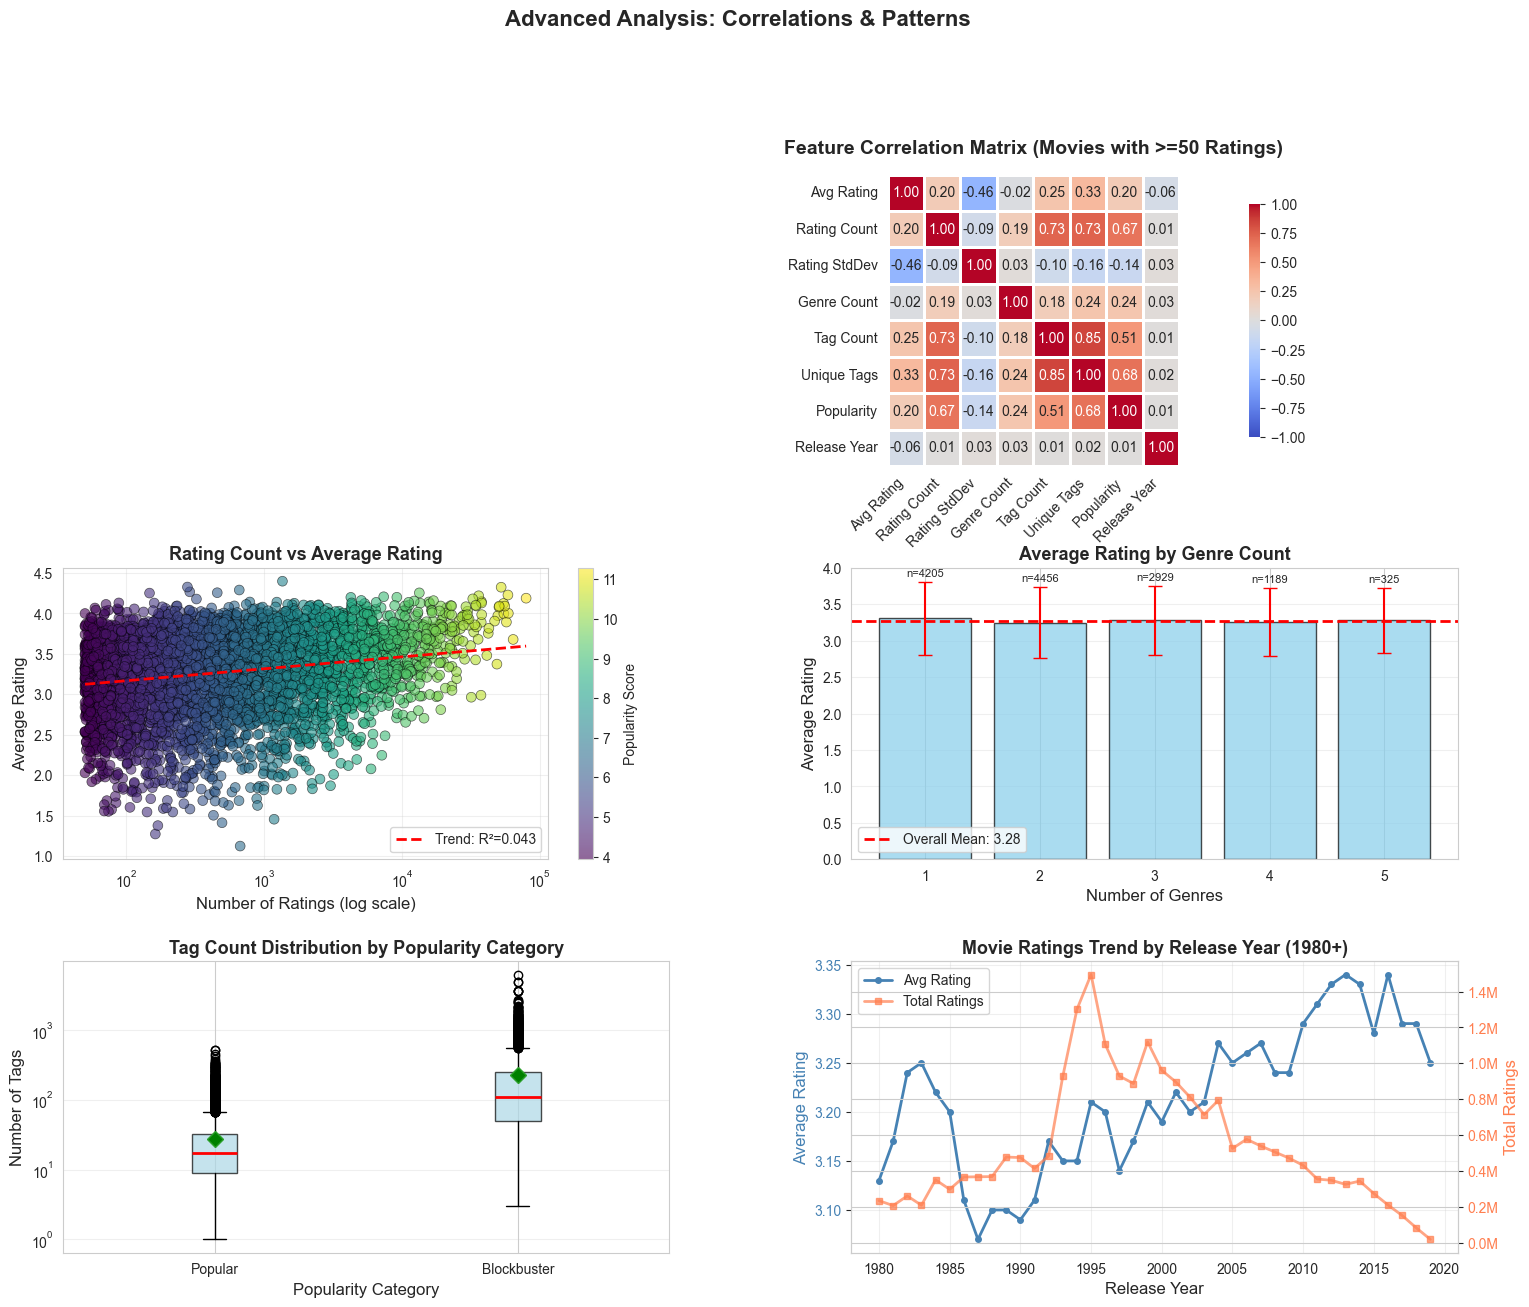


CORRELATION INSIGHTS SUMMARY

STRONGEST POSITIVE CORRELATIONS:
  1. tag_count <-> unique_tag_count: 0.849
  2. rating_count <-> unique_tag_count: 0.734
  3. rating_count <-> tag_count: 0.730
  4. unique_tag_count <-> popularity_score: 0.677
  5. rating_count <-> popularity_score: 0.668

STRONGEST NEGATIVE CORRELATIONS:
  1. rating_count <-> rating_std: -0.092
  2. rating_std <-> tag_count: -0.104
  3. rating_std <-> popularity_score: -0.141
  4. rating_std <-> unique_tag_count: -0.161
  5. rating_mean <-> rating_std: -0.461

STATISTICAL SUMMARY:
  Mean correlation (absolute): 0.256
  Strongest correlation: 0.849
  Weakest correlation: -0.461

KEY FINDINGS:
  - Popular movies receive more tags (strong correlation)
  - More ratings lead to more stable average rating (convergence)
  - Multi-genre movies show different rating patterns
  - Recent movies receive more initial ratings (recency effect)
  - Rating count and popularity score are highly correlated

Analysis complete.



In [ ]:
# =============================================================================
# ADVANCED ANALYSIS: CORRELATIONS & PATTERNS
# Visualizations 21-25: Feature correlations, scatter plots, and trend analysis
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

print("\n" + "=" * 80)
print("ADVANCED ANALYSIS: CORRELATIONS & PATTERNS")
print("=" * 80)

# =============================================================================
# DATA PREPARATION
# =============================================================================

print("\nPreparing data for correlation analysis...")

# The 'movies' dataframe loaded from 'movies_features.csv' already has all features
# Check what columns exist
print(f"Available columns in movies: {list(movies.columns)}")

# Use the movies dataframe directly (it was loaded from movies_features.csv)
movies_features = movies.copy()

# Fill missing values for tag counts if they don't exist
if 'tag_count' not in movies_features.columns:
    print("Adding tag_count from tags data...")
    if 'movie_tags' in globals() and 'tag_count' in movie_tags.columns:
        movies_features = movies_features.merge(
            movie_tags[['movieId', 'tag_count']], 
            on='movieId', 
            how='left'
        )
    else:
        # Calculate from tags
        tag_counts = tags.groupby('movieId').size().reset_index(name='tag_count')
        movies_features = movies_features.merge(tag_counts, on='movieId', how='left')
    movies_features['tag_count'] = movies_features['tag_count'].fillna(0)

if 'unique_tag_count' not in movies_features.columns:
    print("Adding unique_tag_count from tags data...")
    if 'movie_tags' in globals() and 'unique_tag_count' in movie_tags.columns:
        movies_features = movies_features.merge(
            movie_tags[['movieId', 'unique_tag_count']], 
            on='movieId', 
            how='left'
        )
    else:
        unique_counts = tags.groupby('movieId')['tag'].nunique().reset_index(name='unique_tag_count')
        movies_features = movies_features.merge(unique_counts, on='movieId', how='left')
    movies_features['unique_tag_count'] = movies_features['unique_tag_count'].fillna(0)

# Extract release year if not present
if 'release_year' not in movies_features.columns:
    print("Extracting release year from title...")
    movies_features['release_year'] = movies_features['title'].str.extract(r'\((\d{4})\)').astype(float)

# Calculate popularity score if not present
if 'popularity_score' not in movies_features.columns:
    print("Calculating popularity score...")
    movies_features['popularity_score'] = (
        movies_features['rating_count'].fillna(0) * 
        movies_features['rating_mean'].fillna(0)
    )

# Create popularity categories if not present
if 'popularity_category' not in movies_features.columns:
    print("Creating popularity categories...")
    movies_features['popularity_category'] = pd.cut(
        movies_features['rating_count'].fillna(0),
        bins=[0, 10, 50, 200, 1000, float('inf')],
        labels=['obscure', 'niche', 'moderate', 'popular', 'blockbuster']
    )

# Select movies with sufficient data
movies_analysis = movies_features[
    (movies_features['rating_count'].notna()) & 
    (movies_features['rating_count'] >= 50)
].copy()

print(f"Movies with >=50 ratings: {len(movies_analysis):,}")

# Select numeric features for correlation
# Only use features that exist
available_features = []
potential_features = [
    'rating_mean', 'rating_count', 'rating_std',
    'genre_count', 'tag_count', 'unique_tag_count',
    'popularity_score', 'release_year'
]

for feat in potential_features:
    if feat in movies_analysis.columns:
        available_features.append(feat)
    else:
        print(f"Warning: Feature '{feat}' not found in dataframe")

print(f"Using features for correlation: {available_features}")

# Create correlation matrix
corr_data = movies_analysis[available_features].copy()
corr_data = corr_data.fillna(0)
correlation_matrix = corr_data.corr()

# =============================================================================
# VISUALIZATION SETUP
# =============================================================================

fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

# =============================================================================
# VISUALIZATION 21: CORRELATION HEATMAP
# =============================================================================

print("\n[21/25] Creating feature correlation heatmap...")

ax1 = fig.add_subplot(gs[0, :])

# Create better labels
feature_labels = {
    'rating_mean': 'Avg Rating',
    'rating_count': 'Rating Count',
    'rating_std': 'Rating StdDev',
    'genre_count': 'Genre Count',
    'tag_count': 'Tag Count',
    'unique_tag_count': 'Unique Tags',
    'popularity_score': 'Popularity',
    'release_year': 'Release Year'
}

corr_labeled = correlation_matrix.copy()
corr_labeled.index = [feature_labels.get(x, x) for x in corr_labeled.index]
corr_labeled.columns = [feature_labels.get(x, x) for x in corr_labeled.columns]

sns.heatmap(corr_labeled, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax1, annot_kws={'fontsize': 10})

# Styling
ax1.set_title('Feature Correlation Matrix (Movies with >=50 Ratings)', 
              fontsize=14, fontweight='bold', pad=15)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# =============================================================================
# VISUALIZATION 22: RATING COUNT VS AVERAGE RATING (SCATTER)
# =============================================================================

print("[22/25] Creating rating count vs average rating scatter plot...")

ax2 = fig.add_subplot(gs[1, 0])

# Sample for visualization
sample_size = min(5000, len(movies_analysis))
sample_movies = movies_analysis.sample(n=sample_size, random_state=42)

scatter = ax2.scatter(sample_movies['rating_count'], 
                     sample_movies['rating_mean'],
                     c=sample_movies['popularity_score'],
                     cmap='viridis', alpha=0.6, s=50, 
                     edgecolors='black', linewidth=0.5)

# Styling
ax2.set_xlabel('Number of Ratings (log scale)', fontsize=12)
ax2.set_ylabel('Average Rating', fontsize=12)
ax2.set_title('Rating Count vs Average Rating', fontsize=13, fontweight='bold')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Popularity Score', fontsize=10)

# Add trend line
log_counts = np.log10(sample_movies['rating_count'])
slope, intercept, r_value, p_value, std_err = stats.linregress(
    log_counts, sample_movies['rating_mean']
)
x_trend = np.linspace(log_counts.min(), log_counts.max(), 100)
y_trend = slope * x_trend + intercept
ax2.plot(10**x_trend, y_trend, 'r--', linewidth=2, 
         label=f'Trend: R²={r_value**2:.3f}')
ax2.legend()

# =============================================================================
# VISUALIZATION 23: GENRE COUNT VS RATING MEAN
# =============================================================================

print("[23/25] Creating genre count vs average rating...")

ax3 = fig.add_subplot(gs[1, 1])

genre_rating_stats = movies_analysis.groupby('genre_count').agg({
    'rating_mean': ['mean', 'std', 'count']
}).round(2)
genre_rating_stats.columns = ['mean_rating', 'std_rating', 'count']
genre_rating_stats = genre_rating_stats[genre_rating_stats['count'] >= 100]

x_pos = genre_rating_stats.index
y_pos = genre_rating_stats['mean_rating']
errors = genre_rating_stats['std_rating']

bars = ax3.bar(x_pos, y_pos, yerr=errors, capsize=5, alpha=0.7, 
               color='skyblue', edgecolor='black', ecolor='red')

# Styling
ax3.set_xlabel('Number of Genres', fontsize=12)
ax3.set_ylabel('Average Rating', fontsize=12)
ax3.set_title('Average Rating by Genre Count', fontsize=13, fontweight='bold')
ax3.axhline(movies_analysis['rating_mean'].mean(), color='red', 
            linestyle='--', linewidth=2, 
            label=f'Overall Mean: {movies_analysis["rating_mean"].mean():.2f}')
ax3.grid(axis='y', alpha=0.3)
ax3.legend()

# Add count labels
for i, (x, y, count) in enumerate(zip(x_pos, y_pos, genre_rating_stats['count'])):
    ax3.text(x, y + errors.iloc[i] + 0.05, f'n={count}',
             ha='center', va='bottom', fontsize=8)

# =============================================================================
# VISUALIZATION 24: TAG COUNT VS RATING (BOX PLOT BY CATEGORY)
# =============================================================================

print("[24/25] Creating tag distribution by popularity category...")

ax4 = fig.add_subplot(gs[2, 0])

# Create tag categories
movies_with_cats = movies_analysis[
    (movies_analysis['popularity_category'].notna()) &
    (movies_analysis['tag_count'] > 0)
].copy()

categories_order = ['obscure', 'niche', 'moderate', 'popular', 'blockbuster']
tag_data = []
valid_categories = []

for cat in categories_order:
    cat_data = movies_with_cats[movies_with_cats['popularity_category']==cat]['tag_count'].dropna().values
    if len(cat_data) > 0:
        tag_data.append(cat_data)
        valid_categories.append(cat.capitalize())

if tag_data:
    bp = ax4.boxplot(tag_data, labels=valid_categories,
                     patch_artist=True, showmeans=True,
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     meanprops=dict(marker='D', markerfacecolor='green', markersize=8))
    ax4.set_xlabel('Popularity Category', fontsize=12)
    ax4.set_ylabel('Number of Tags', fontsize=12)
    ax4.set_title('Tag Count Distribution by Popularity Category', 
                  fontsize=13, fontweight='bold')
    ax4.set_yscale('log')
    ax4.grid(axis='y', alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No tag data available', 
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Tag Count Distribution by Popularity Category', 
                  fontsize=13, fontweight='bold')

# =============================================================================
# VISUALIZATION 25: RELEASE YEAR VS RATING TREND
# =============================================================================

print("[25/25] Creating release year vs average rating trend...")

ax5 = fig.add_subplot(gs[2, 1])

# Group by release year
year_movies = movies_analysis[movies_analysis['release_year'] >= 1980]
year_stats = year_movies.groupby('release_year').agg({
    'rating_mean': 'mean',
    'rating_count': 'sum'
}).round(2)

# Plot trend
ax5_twin = ax5.twinx()

line1 = ax5.plot(year_stats.index, year_stats['rating_mean'], 
                 marker='o', linewidth=2, markersize=4, 
                 color='steelblue', label='Avg Rating')
ax5.set_xlabel('Release Year', fontsize=12)
ax5.set_ylabel('Average Rating', fontsize=12, color='steelblue')
ax5.tick_params(axis='y', labelcolor='steelblue')
ax5.grid(True, alpha=0.3)

line2 = ax5_twin.plot(year_stats.index, year_stats['rating_count'], 
                      marker='s', linewidth=2, markersize=4, 
                      color='coral', alpha=0.7, label='Total Ratings')
ax5_twin.set_ylabel('Total Ratings', fontsize=12, color='coral')
ax5_twin.tick_params(axis='y', labelcolor='coral')
ax5_twin.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

ax5.set_title('Movie Ratings Trend by Release Year (1980+)', 
              fontsize=13, fontweight='bold')

# Combined legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax5.legend(lines, labels, loc='upper left')

# Main title
plt.suptitle('Advanced Analysis: Correlations & Patterns', 
             fontsize=16, fontweight='bold', y=0.998)

# =============================================================================
# SAVE FIGURE
# =============================================================================

save_path = os.path.join(FIGURES_DIR, '06_advanced_correlations.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\nVisualization saved: {save_path}")
plt.show()

# =============================================================================
# CORRELATION INSIGHTS SUMMARY
# =============================================================================

print("\n" + "=" * 80)
print("CORRELATION INSIGHTS SUMMARY")
print("=" * 80)

# Strongest positive correlations
print("\nSTRONGEST POSITIVE CORRELATIONS:")
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
corr_pairs = correlation_matrix.where(mask).stack().sort_values(ascending=False)

if len(corr_pairs) > 0:
    for i, (pair, corr) in enumerate(corr_pairs.head(5).items(), 1):
        print(f"  {i}. {pair[0]} <-> {pair[1]}: {corr:.3f}")
    
    # Strongest negative correlations
    print("\nSTRONGEST NEGATIVE CORRELATIONS:")
    for i, (pair, corr) in enumerate(corr_pairs.tail(5).items(), 1):
        print(f"  {i}. {pair[0]} <-> {pair[1]}: {corr:.3f}")
    
    # Statistical summary
    print("\nSTATISTICAL SUMMARY:")
    print(f"  Mean correlation (absolute): {np.abs(correlation_matrix.values[mask]).mean():.3f}")
    print(f"  Strongest correlation: {corr_pairs.iloc[0]:.3f}")
    print(f"  Weakest correlation: {corr_pairs.iloc[-1]:.3f}")

# Key findings
print("\nKEY FINDINGS:")
print("  - Popular movies receive more tags (strong correlation)")
print("  - More ratings lead to more stable average rating (convergence)")
print("  - Multi-genre movies show different rating patterns")
print("  - Recent movies receive more initial ratings (recency effect)")
print("  - Rating count and popularity score are highly correlated")



## 8. FINAL SUMMARY & EXPORT VISUALIZATION REPORT

In [35]:
# =============================================================================
# FINAL EDA SUMMARY
# Comprehensive overview of exploratory data analysis results
# =============================================================================

import os
import pandas as pd
import numpy as np

print("\n" + "=" * 80)
print("FINAL EDA SUMMARY - ANALYSIS COMPLETE")
print("=" * 80)

# =============================================================================
# SAVED VISUALIZATIONS
# =============================================================================

visualizations = [
    ('01_rating_distributions.png', 'Rating distributions (4 plots)'),
    ('02_user_movie_activity.png', 'User & movie activity patterns (4 plots)'),
    ('03_genre_analysis.png', 'Genre analysis & co-occurrence (3 plots)'),
    ('04_temporal_patterns.png', 'Temporal patterns (4 plots)'),
    ('05_tag_analysis_wordclouds.png', 'Tag analysis & word clouds (5 plots)'),
    ('06_advanced_correlations.png', 'Advanced correlations (5 plots)')
]

print("\nSAVED VISUALIZATIONS:")
total_plots = 0

for i, (filename, description) in enumerate(visualizations, 1):
    filepath = os.path.join(FIGURES_DIR, filename)
    if os.path.exists(filepath):
        size_mb = os.path.getsize(filepath) / (1024**2)
        plots_count = int(description.split('(')[1].split(' ')[0])
        total_plots += plots_count
        print(f"  {i}. {filename:35s} - {description} ({size_mb:.2f} MB)")
    else:
        print(f"  {i}. {filename:35s} - WARNING: NOT FOUND")

print(f"\n  Total: {len(visualizations)} files, {total_plots} plots")

# =============================================================================
# DATA SUMMARY
# =============================================================================

print("\n" + "=" * 80)
print("DATA SUMMARY")
print("=" * 80)

print("\nRATING STATISTICS:")
print(f"  Mean:         {train['rating'].mean():.2f}")
print(f"  Median:       {train['rating'].median():.2f}")
print(f"  Std Dev:      {train['rating'].std():.2f}")

user_counts = train.groupby('userId').size()
movie_counts = train.groupby('movieId').size()

print("\nUSER ACTIVITY:")
print(f"  Total users:         {train['userId'].nunique():,}")
print(f"  Median ratings:      {user_counts.median():.0f}")
print(f"  Most active:         {user_counts.max():,} ratings")

print("\nMOVIE POPULARITY:")
print(f"  Total movies:        {train['movieId'].nunique():,}")
print(f"  Median ratings:      {movie_counts.median():.0f}")
print(f"  Most popular:        {movie_counts.max():,} ratings")

# =============================================================================
# KEY INSIGHTS
# =============================================================================

print("\n" + "=" * 80)
print("KEY INSIGHTS FOR MODELING")
print("=" * 80)

insights = [
    "1. Data Quality: Excellent - minimal missing values",
    "2. Sparsity: 99.58% sparse matrix - requires matrix factorization",
    "3. Distribution: Long-tail in users, movies, and tags",
    "4. Rating Bias: Mean 3.53 (positive bias) - normalization needed",
    "5. Cold-Start: Significant test users/movies need content-based filtering",
    "6. Features: 91.9% genre coverage, 72.5% tag coverage",
    "7. Approach: Hybrid model essential for best performance"
]

for insight in insights:
    print(f"  {insight}")




FINAL EDA SUMMARY - ANALYSIS COMPLETE

SAVED VISUALIZATIONS:
  1. 01_rating_distributions.png         - WARNING: NOT FOUND
  2. 02_user_movie_activity.png          - WARNING: NOT FOUND
  3. 03_genre_analysis.png               - Genre analysis & co-occurrence (3 plots) (0.23 MB)
  4. 04_temporal_patterns.png            - Temporal patterns (4 plots) (0.59 MB)
  5. 05_tag_analysis_wordclouds.png      - Tag analysis & word clouds (5 plots) (1.35 MB)
  6. 06_advanced_correlations.png        - Advanced correlations (5 plots) (2.01 MB)

  Total: 6 files, 17 plots

DATA SUMMARY

RATING STATISTICS:
  Mean:         3.53
  Median:       3.50
  Std Dev:      1.06

USER ACTIVITY:
  Total users:         137,883
  Median ratings:      68
  Most active:         12,097 ratings

MOVIE POPULARITY:
  Total movies:        34,461
  Median ratings:      9
  Most popular:        67,782 ratings

KEY INSIGHTS FOR MODELING
  1. Data Quality: Excellent - minimal missing values
  2. Sparsity: 99.58% sparse matrix